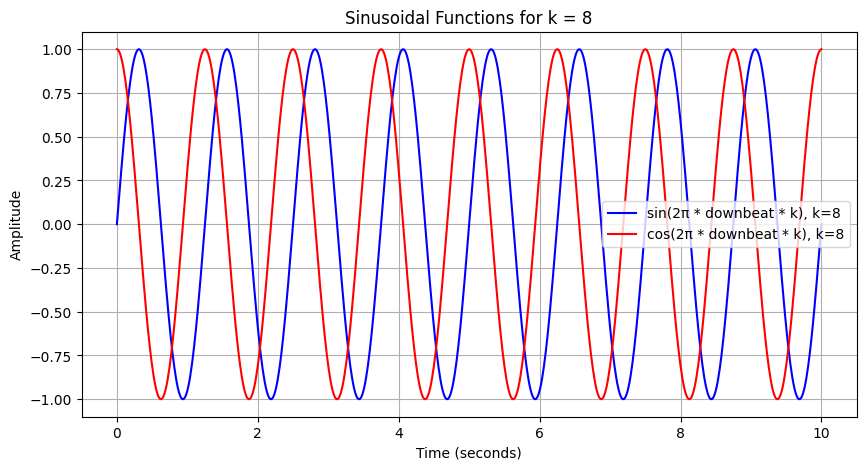

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for sinusoidal functions
fps = 75
duration = 10  # seconds
K = 32  # highest frequency component
time_vector = np.linspace(0, duration, fps * duration)
vector_downbeat = np.linspace(0, 1, len(time_vector))  # Example downbeat ramp

# Sinusoidal functions for k = 32
k = 8
sin_wave = np.sin(2 * np.pi * vector_downbeat * k)
cos_wave = np.cos(2 * np.pi * vector_downbeat * k)

# Plotting the 32nd sinusoidal function
plt.figure(figsize=(10, 5))
plt.plot(time_vector, sin_wave, label=f'sin(2π * downbeat * k), k={k}', color='blue')
plt.plot(time_vector, cos_wave, label=f'cos(2π * downbeat * k), k={k}', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Sinusoidal Functions for k = {k}')
plt.legend()
plt.grid(True)
plt.show()


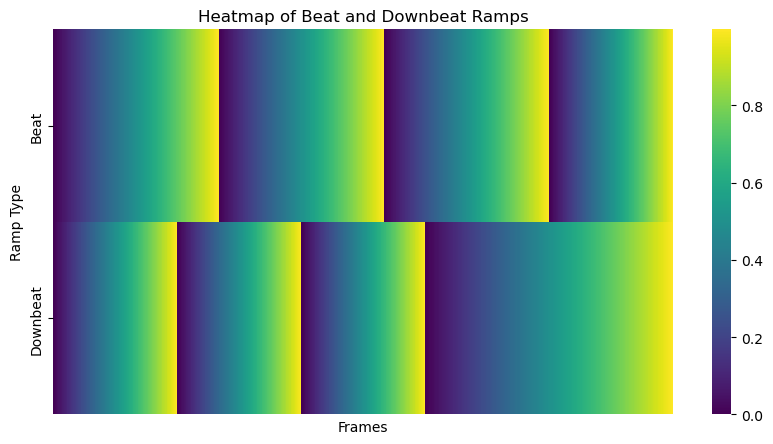

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
fps = 75
duration = 10
total_frames = int(np.ceil(duration * fps))
beat_positions = np.array([0, 200, 400, 600, total_frames])  # Example positions in frames
downbeat_positions = np.array([0, 150, 300, 450, total_frames])  # Example positions for downbeats

# Function to create ramps between beats
def ramps(positions, size):
    result = np.zeros(size)
    for a, b in zip(positions[:-1], positions[1:]):
        if b > a:  # To avoid negative or zero length segments
            result[a:b] = np.linspace(0, 1, b - a, endpoint=False)
    return result

# Create beat and downbeat ramps
beat_vector = ramps(beat_positions, total_frames)
downbeat_vector = ramps(downbeat_positions, total_frames)

# Plotting heatmap
ramp_matrix = np.vstack([beat_vector, downbeat_vector])

plt.figure(figsize=(10, 5))
sns.heatmap(ramp_matrix, cmap="viridis", cbar=True, xticklabels=False, yticklabels=["Beat", "Downbeat"])
plt.title("Heatmap of Beat and Downbeat Ramps")
plt.xlabel("Frames")
plt.ylabel("Ramp Type")
plt.show()


In [2]:
def extract_downbeats(audio_path, fps=100, duration=10):
    # Load the audio file
    audio, rate = torchaudio.load(audio_path)
    
    # Calculate the number of samples for the specified duration
    num_samples = int(duration * rate)
    
    # Slice the audio to the first 10 seconds
    if audio.shape[1] > num_samples:
        audio = audio[:, :num_samples]
    
    # Save the sliced audio to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as temp_audio_file:
        temp_audio_path = temp_audio_file.name
        torchaudio.save(temp_audio_path, audio, rate)
    
    # Process the temporary audio file to extract downbeats
    proc = madmom.features.downbeats.DBNDownBeatTrackingProcessor(beats_per_bar=[4], fps=fps)
    act = madmom.features.downbeats.RNNDownBeatProcessor(fps=fps)(temp_audio_path)
    downbeats = proc(act)
    
    # Filter downbeats to keep only the ones labeled as downbeats
    filtered_downbeats = downbeats[downbeats[:, 1] == 1, 0]
    
    # Delete the temporary file
    os.remove(temp_audio_path)
    
    return filtered_downbeats

def extract_beats(audio_path, fps=100, duration=10):
    # Load the audio file
    audio, rate = torchaudio.load(audio_path)
    
    # Calculate the number of samples for the specified duration
    num_samples = int(duration * rate)
    
    # Slice the audio to the first 10 seconds
    if audio.shape[1] > num_samples:
        audio = audio[:, :num_samples]
    
    # Save the sliced audio to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as temp_audio_file:
        temp_audio_path = temp_audio_file.name
        torchaudio.save(temp_audio_path, audio, rate)
    
    # Process the temporary audio file to extract beats
    beat_act = madmom.features.beats.RNNBeatProcessor(fps=fps)(temp_audio_path)
    beat_proc = madmom.features.beats.BeatDetectionProcessor(fps=fps)
    beats = beat_proc(beat_act)
    
    # Delete the temporary file
    os.remove(temp_audio_path)
    
    return beats


def create_positional_embeddings(beat_times, downbeat_times, audio_duration, fps=75, K=32):
    total_frames = int(np.ceil(audio_duration * fps))
    print ('total frames: ', total_frames)
    
    def ramps(positions, size):
        result = np.zeros(size)
        for a, b in zip(positions[:-1], positions[1:]):
            result[a:b] = np.linspace(0, 1, b - a, endpoint=False)
        missing = positions[0]
        if missing:
            piece = result[positions[0]:positions[1]]
            pieces = np.tile(piece, missing // len(piece) + 1)
            result[:missing] = pieces[-missing:]
        missing = size - positions[-1]
        if missing:
            piece = result[positions[-2]:positions[-1]]
            pieces = np.tile(piece, missing // len(piece) + 1)
            result[-missing:] = pieces[:missing]
        return result

    time_vector = np.linspace(0, audio_duration, total_frames)
    vector_downbeat = ramps((downbeat_times * fps).astype(int), total_frames)
    vector_beat = ramps((beat_times * fps).astype(int), total_frames)

    frequencies = np.arange(1, K + 1)
    embeddings_downbeat = []
    embeddings_beat = []

    for k in frequencies:
        embeddings_downbeat.append(np.sin(2 * np.pi * vector_downbeat * k))
        embeddings_downbeat.append(np.cos(2 * np.pi * vector_downbeat * k))
        embeddings_beat.append(np.sin(2 * np.pi * vector_beat * k))
        embeddings_beat.append(np.cos(2 * np.pi * vector_beat * k))

    embeddings_downbeat = np.stack(embeddings_downbeat, axis=1)
    embeddings_beat = np.stack(embeddings_beat, axis=1)
    embeddings = np.hstack((embeddings_downbeat, embeddings_beat))

    return torch.from_numpy(embeddings).float()


Extracted beat times: [0.13 0.63 1.16 1.68 2.2  2.72 3.25 3.77 4.3  4.82 5.34 5.86 6.38 6.9
 7.42 7.94 8.46 8.98 9.5 ]
Extracted downbeat times: [2.2  4.3  6.37 8.45]
total frames:  750
Shape of positional embeddings: (750, 128)
128 eta


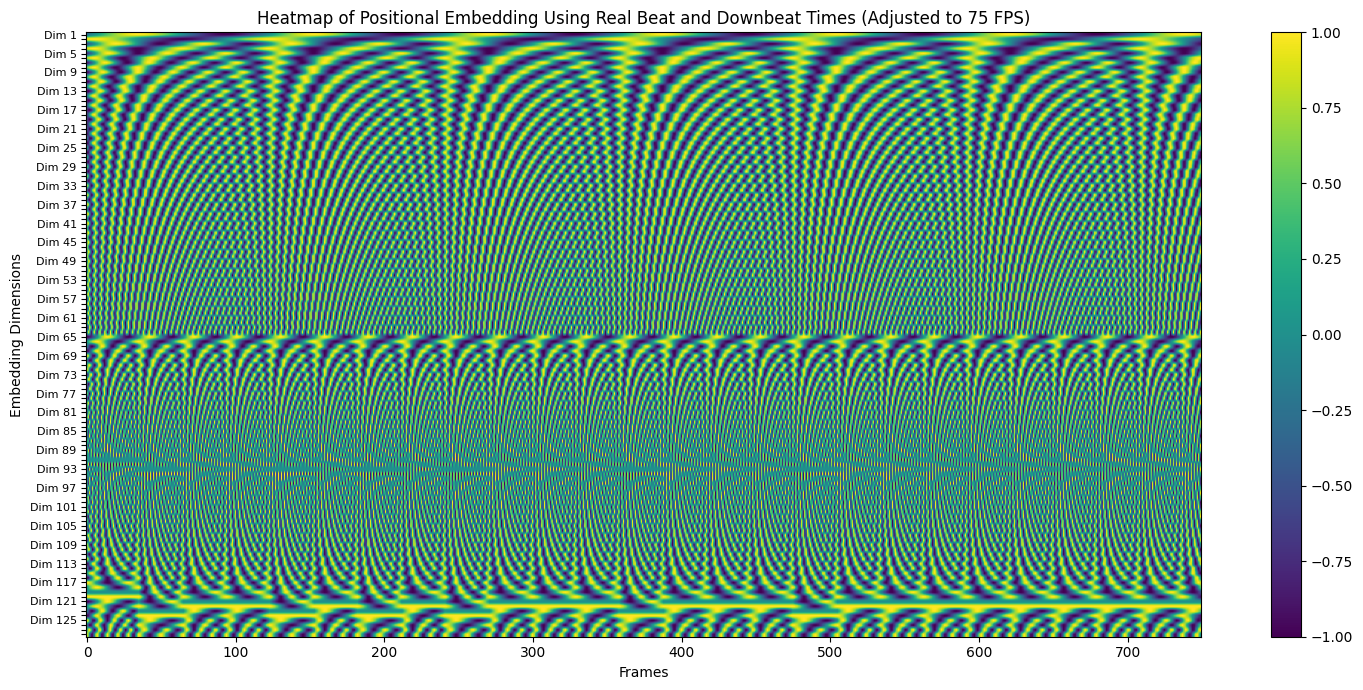

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchaudio
import tempfile
import madmom
import os

# Assuming extract_beats(), extract_downbeats(), and create_positional_embeddings() are defined as in your original script.

# Set the audio path to a real file
audio_path = '../processed_dataset/suryodaya/suryodaya_1_20bars/suryodaya_1_full_instrumental.wav'  # Replace with the path to your audio file

# Extract beats and downbeats from the real audio file
fps_extraction = 100  # FPS for extraction
duration = 10  # Analyze the first 10 seconds
beat_times = extract_beats(audio_path, fps=fps_extraction, duration=duration)
downbeat_times = extract_downbeats(audio_path, fps=fps_extraction, duration=duration)

# Check if beat_times and downbeat_times are correctly extracted
print("Extracted beat times:", beat_times)
print("Extracted downbeat times:", downbeat_times)

# Convert extracted times to match the positional encoding fps (75)
fps_encoding = 75
scaling_factor = fps_encoding / fps_extraction

# Adjust the beat and downbeat times to match the fps of positional embeddings
beat_times_adjusted = beat_times * scaling_factor
downbeat_times_adjusted = downbeat_times * scaling_factor

# Create positional embeddings using the given function with adjusted beat and downbeat times
embeddings = create_positional_embeddings(beat_times_adjusted, downbeat_times_adjusted, duration, fps=fps_encoding, K=32)

# Convert to numpy for visualization
embeddings_np = embeddings.numpy()

# Verify the shape of the embeddings (should be total_frames x 64)
print("Shape of positional embeddings:", embeddings_np.shape)

# Plotting the heatmap using Matplotlib
fig, ax = plt.subplots(figsize=(15, 7))

cax = ax.imshow(embeddings_np.T, aspect='auto', cmap='viridis')
ax.set_title("Heatmap of Positional Embedding Using Real Beat and Downbeat Times (Adjusted to 75 FPS)")
ax.set_xlabel("Frames")
ax.set_ylabel("Embedding Dimensions")

# Adding ticks for dimensions

print(embeddings_np.shape[1], 'eta')
yticks = [f"Dim {i+1}" if i % 4 == 0 else "" for i in range(embeddings_np.shape[1])]
ax.set_yticks(np.arange(len(yticks)))
ax.set_yticklabels(yticks, fontsize=8)

# Adding color bar to show the scale
fig.colorbar(cax)

plt.tight_layout()
plt.show()


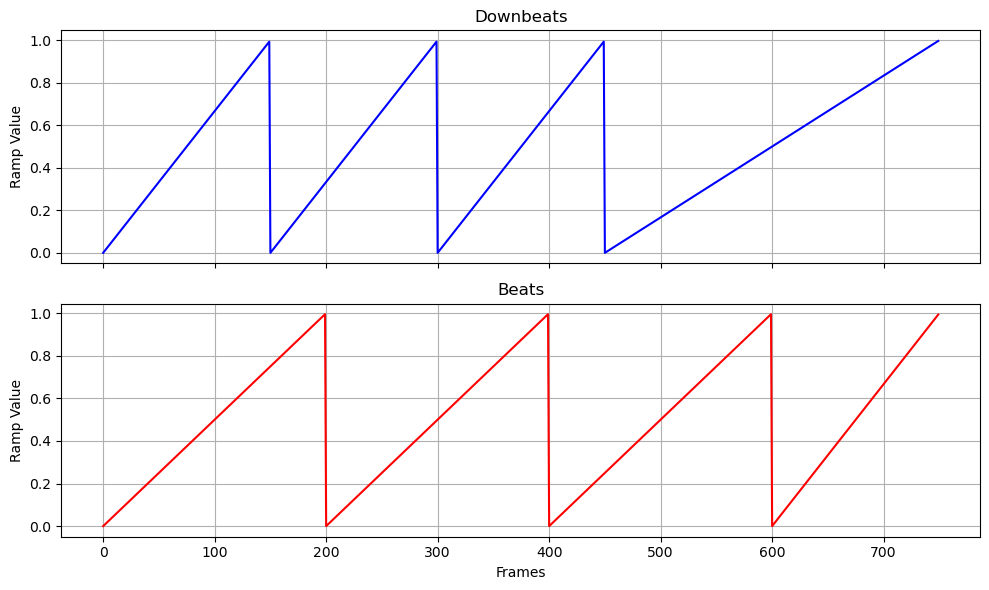

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fps = 75
duration = 10  # seconds
total_frames = int(np.ceil(duration * fps))
beat_positions = np.array([0, 200, 400, 600, total_frames])  # Example positions in frames
downbeat_positions = np.array([0, 150, 300, 450, total_frames])  # Example positions for downbeats

# Function to create ramps between beats
def ramps(positions, size):
    result = np.zeros(size)
    for a, b in zip(positions[:-1], positions[1:]):
        if b > a:  # Ensure the range is valid
            segment_length = b - a
            if segment_length <= len(result[a:b]):
                result[a:b] = np.linspace(0, 1, segment_length, endpoint=False)
            else:
                # If the segment is longer than expected, adjust to prevent broadcasting issues
                result[a:b] = np.linspace(0, 1, len(result[a:b]), endpoint=False)
    return result

# Create beat and downbeat ramps
beat_vector = ramps(beat_positions, total_frames)
downbeat_vector = ramps(downbeat_positions, total_frames)

# Plotting line plots for beat and downbeat ramps
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot for downbeats
axs[0].plot(range(total_frames), downbeat_vector, color='blue')
axs[0].set_title("Downbeats")
axs[0].set_ylabel("Ramp Value")
axs[0].grid(True)

# Plot for beats
axs[1].plot(range(total_frames), beat_vector, color='red')
axs[1].set_title("Beats")
axs[1].set_xlabel("Frames")
axs[1].set_ylabel("Ramp Value")
axs[1].grid(True)

plt.tight_layout()
plt.show()
